In [1]:
import sys
sys.path.append('../')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from fb_gp import saas_fbgp
import numpy as np
import time
from jaxns.framework.model import Model
from jaxns.framework.prior import Prior
import jax
import tensorflow_probability.substrates.jax as tfp
import jax.numpy as jnp
tfpd = tfp.distributions
from jaxns import NestedSampler, TerminationCondition, resample
from jaxns.framework.model import Model
from jaxns.framework.prior import Prior
from jax import random,vmap, grad
from jax.lax import while_loop

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from acquisition import EI, IPV, optim_scipy_bh
import scipy.optimize
from scipy.stats import qmc
from jaxns import NestedSampler
import corner
from nested_sampler import nested_sampling_jaxns, nested_sampling_Dy
from getdist import plots,MCSamples,loadMCSamples


# matplotlib.rc('font', size=16,family='serif')
# matplotlib.rc('legend', fontsize=16)

### EI test

In [2]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 8
ndim = 2
train_x_unit = qmc.Sobol(ndim, scramble=True).random(ninit)

def loglike(X):
    logpdf = -0.25*(5*(0.2-X[:,0]))**2 - (20*(X[:,1]/4 - X[:,0]**4))**2
    return logpdf.reshape(-1,1)

param_bounds = np.array([[-1,1],[-1,2]]).T

print(param_bounds[1],param_bounds[0])

# print(param_bounds[0,1])

def input_standardize(x):
    """
    Project from original domain to unit hypercube, X is N x d shaped, param_bounds are 2 x d
    """
    x =  (x - param_bounds[0])/(param_bounds[1] - param_bounds[0])
    return x

def input_unstandardize(x):
    """
    Project from unit hypercube to original domain, X is N x d shaped, param_bounds are 2 x d
    """
    x = x * (param_bounds[1] - param_bounds[0]) + param_bounds[0]
    return x

train_x = input_unstandardize(train_x_unit)

train_y = loglike(train_x)
# print(train_x,train_x_unit)
# print(train_x.shape,train_y.shape)

# train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x_unit,train_y,noise=1e-4)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)


[1 2] [-1 -1]
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:00<00:00, 1080.88it/s, 7 steps of size 3.34e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 2.77s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]    366.32   1718.51      1.99      0.25     23.19     35.37      1.01
_kernel_inv_length_sq[1]     21.73     63.25      2.82      0.20     40.94     39.64      0.99
        kernel_length[0]      0.35      0.19      0.37      0.03      0.53     26.26      0.97
        kernel_length[1]      0.49      1.29      0.25      0.05      0.46     36.10      1.01
            kernel_tausq     11.54     17.61      3.53      0.09     45.43     27.44      1.04
              kernel_var      5.34      4.29      3.98      0.87     12.12     17.64      1.15

Number of divergences: 0


In [ ]:
nsteps = 16 # 32
mc_points_size = 16
start = time.time()
for i in range(nsteps):
    samples_unit, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    size = len(samples_unit)
    mc_points = samples_unit[::int(size/mc_points_size),:]
    acq_func = EI(gp,gp.train_y.max()) # IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform(0,1,ndim)
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/5,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x_unit = jnp.atleast_2d(results.x)
    next_x = input_unstandardize(next_x_unit)
    next_y = loglike(next_x)
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    train_x_unit = input_standardize(train_x)
    gp = saas_fbgp(train_x_unit,train_y,noise=1e-4)
    gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    print(f"----------------------Step {i+1} complete----------------------\n")

print(f"BO took {time.time() - start:.2f} s ")

INFO:[NS]: Nested Sampling took 2.68s
INFO:[NS]: jaxns did 15519 likelihood evaluations


LogZ info :logz_mean: = 84.9654, dlogz: = 0.3675, 


INFO:[AQ]: Acquisition optimization took 2.39 s


Next point at x = [0.43169039 0.29190909] with acquisition function value = -0.412221222696461


sample: 100%|██████████| 512/512 [00:00<00:00, 692.44it/s, 7 steps of size 4.65e-01. acc. prob=0.81]
INFO:[GP]: MCMC elapsed time: 1.10s


----------------------Step 1 complete----------------------



AttributeError: 'function' object has no attribute '_clear_cache'

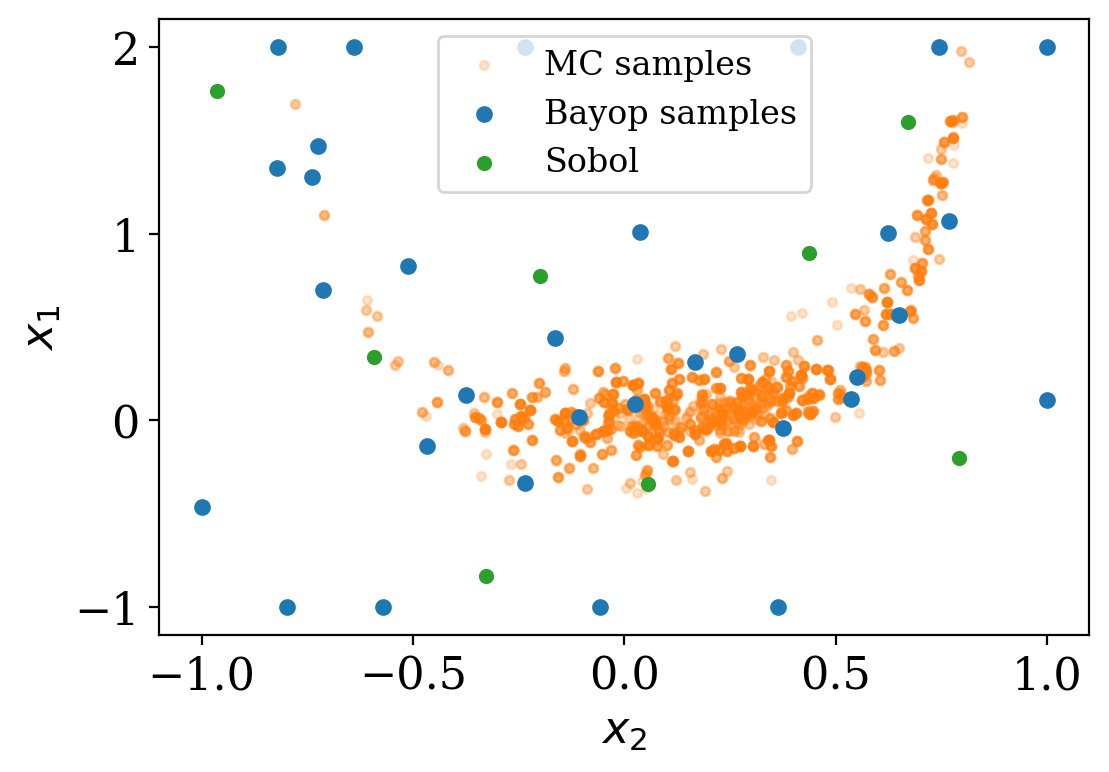

In [7]:
samples = input_unstandardize(samples_unit)

fig,ax = plt.subplots(1,int(ndim/2),figsize=(6,4))
# ax.scatter(samples_unit[:,0],samples_unit[:,0+1],s=10,label='MC samples unit',color='C3',alpha=0.2)
ax.scatter(samples[:,0],samples[:,0+1],s=10,label='MC samples',color='C1',alpha=0.2)
ax.scatter(train_x[ninit:,0],train_x[ninit:,0+1],s=25,label='Bayop samples',color='C0')
ax.scatter(train_x[:ninit,0],train_x[:ninit,0+1],s=20,label='Sobol',color='C2')
ax.set_ylabel(r'$x_1$')
ax.set_xlabel(r'$x_2$')
    # x.axvline(f_mean[2*i],ls='-.',color='k')
    # x.axhline(f_mean[2*i + 1],ls='-.',color='k')
ax.legend(fontsize=12)

In [8]:
samples_unit, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,num_samples_equal=1000,difficult_model=True)
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))
samples = input_unstandardize(samples_unit)

INFO:[NS]: Nested Sampling took 5.01s
INFO:[NS]: jaxns did 135803 likelihood evaluations


LogZ logz_mean: -3.0156, dlogz: 0.1642, 


In [ ]:
# add result from nested sampler on actual

def prior_transform(x):
    x1,x2 = x
    x1 = -1. + x1*2.
    x2 = -1 + x2*3
    return x1,x2
from dynesty import DynamicNestedSampler, NestedSampler

def loglike(X):
    logpdf = -0.25*(5*(0.2-X[0]))**2 - (20*(X[1]/4 - X[0]**4))**2
    return logpdf

dns = DynamicNestedSampler(loglike,prior_transform=prior_transform,ndim=2)
dns.run_nested(print_progress=True,dlogz_init=0.001)
res = dns.results  # grab our results

logz_true = res['logz'][-1]

In [9]:
### Run jaxns directly on loglike

def loglike(X):
    logpdf = -0.25*(5*(0.2-X[0]))**2 - (20*(X[1]/4 - X[0]**4))**2
    return logpdf


def prior_model():
    x = yield Prior(tfpd.Uniform(low=jnp.array([-1,-1]), high= jnp.array([1,2])), name='x')
    return x


model = Model(prior_model=prior_model,log_likelihood=loglike)

model.sanity_check(key=jax.random.PRNGKey(0), S=100)

from jaxns import NestedSampler, TerminationCondition

start = time.time()
ns = NestedSampler(model=model, max_samples=1e5,parameter_estimation=True,difficult_model=True)
term_cond = TerminationCondition(dlogZ=0.01)
# Run the sampler
termination_reason, state = ns(jax.random.PRNGKey(42),term_cond=term_cond)
# Get the results
results = ns.to_results(termination_reason=termination_reason, state=state)
print(f"Nested Sampling took {time.time() - start:.2f}s")
print(f"jaxns did {results.total_num_likelihood_evaluations} likelihood evaluations")
logz_dict = {"logz_mean": results.log_Z_mean, "dlogz": results.log_Z_uncert}
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

samples_jns = resample(key=jax.random.PRNGKey(0),
                    samples=results.samples,
                    log_weights=results.log_dp_mean,
                    replace=True,)
print(samples_jns['x'].shape)

INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


Nested Sampling took 2.87s
jaxns did 150677 likelihood evaluations
LogZ logz_mean: -3.0650, dlogz: 0.1648, 
(1612, 2)


Removed no burn in
Removed no burn in


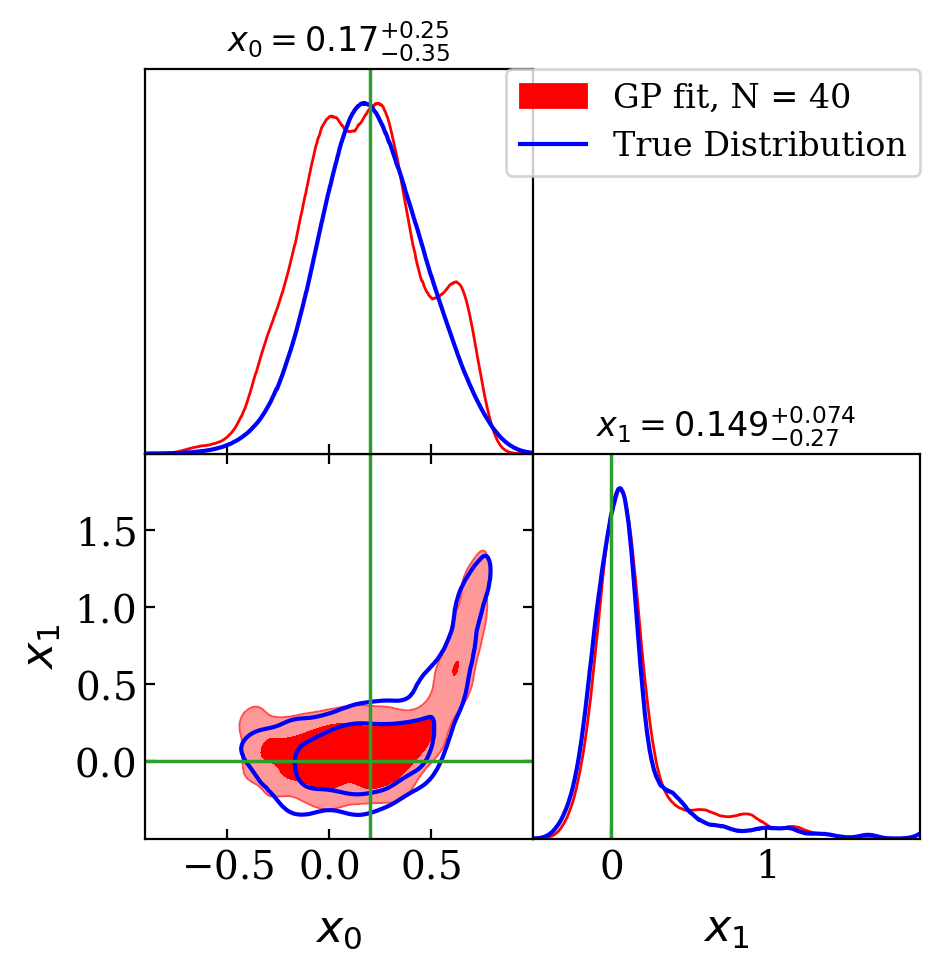

In [12]:
# test_samples = np.random.multivariate_normal(mean=f_mean,cov=cov,size=int(1e5))
labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  param_bounds.T
f_mean = np.array([0.2,0.])
jns_samples = MCSamples(samples=samples_jns['x'][::4],names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::4],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=2.5,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,jns_samples], names,filled=[True,False],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} ','True Distribution'],
                                contour_lws=[1,1.5],markers = dict(zip(names,f_mean)),
                                marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'},title_limit=1 ) # type: ignore

for i in range(ndim):
    ax = g.subplots[i,i]
    ax.axvline(f_mean[i], color='C2', ls='-',lw=1.25)

### IPV 

In [21]:
ninit = 16
ndim = 2

train_x_unit = qmc.Sobol(ndim, scramble=True).random(ninit)

train_x = input_unstandardize(train_x_unit)

def loglike(X):
    logpdf = -0.25*(5*(0.2-X[:,0]))**2 - (20*(X[:,1]/4 - X[:,0]**4))**2
    return logpdf.reshape(-1,1)
train_y = loglike(train_x)
print("Testing lightweight implementation")

gp = saas_fbgp(train_x_unit,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)

Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:01<00:00, 896.45it/s, 7 steps of size 4.79e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 1.34s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]    104.90    306.39     13.04      1.02     96.32     17.40      1.04
_kernel_inv_length_sq[1]      2.59      3.30      1.03      0.19      7.29     15.71      0.98
        kernel_length[0]      0.22      0.06      0.22      0.10      0.28     31.38      1.01
        kernel_length[1]      1.01      1.18      0.75      0.29      1.23     19.00      1.03
            kernel_tausq      4.05      7.59      1.51      0.04      9.35     46.00      0.98
              kernel_var      8.79      6.22      8.66      1.19     18.19     41.00      0.97

Number of divergences: 0


In [22]:
nsteps = 44 # 32
mc_points_size = 16
start = time.time()
for i in range(nsteps):
    samples_unit, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
    print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
    size = len(samples_unit)
    mc_points = samples_unit[::int(size/mc_points_size),:]
    acq_func = IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    # print(ndim)
    x0 =  np.random.uniform(0,1,ndim)
    # print(x0.shape)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=15,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    # next_val = results.fun 
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x_unit = jnp.atleast_2d(results.x)
    next_x = input_unstandardize(next_x_unit)
    next_y = loglike(next_x)
    # print(next_y.shape)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    train_x_unit = input_standardize(train_x)
    gp = saas_fbgp(train_x_unit,train_y,noise=1e-6)
    gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    print(f"----------------------Step {i+1} complete----------------------\n")


print(f"BO took {time.time() - start:.2f} s ")

INFO:[NS]: Nested Sampling took 3.16s
INFO:[NS]: jaxns did 12304 likelihood evaluations


LogZ info :logz_mean: = 14.4731, dlogz: = 0.3589, 


INFO:[AQ]: Acquisition optimization took 4.56 s


Next point at x = [0.25977265 0.14012858] with acquisition function value = 0.006981674603731662


sample: 100%|██████████| 512/512 [00:00<00:00, 575.08it/s, 15 steps of size 2.66e-01. acc. prob=0.91]
INFO:[GP]: MCMC elapsed time: 1.47s


----------------------Step 1 complete----------------------



INFO:[NS]: Nested Sampling took 2.20s
INFO:[NS]: jaxns did 15759 likelihood evaluations


LogZ info :logz_mean: = 14.3755, dlogz: = 0.3725, 


INFO:[AQ]: Acquisition optimization took 3.17 s


Next point at x = [0.78933949 0.55307581] with acquisition function value = 0.0010025897584578624


sample: 100%|██████████| 512/512 [00:00<00:00, 613.64it/s, 7 steps of size 5.38e-01. acc. prob=0.83] 
INFO:[GP]: MCMC elapsed time: 1.37s


----------------------Step 2 complete----------------------



INFO:[NS]: Nested Sampling took 1.97s
INFO:[NS]: jaxns did 11623 likelihood evaluations


LogZ info :logz_mean: = 3.6177, dlogz: = 0.3667, 


INFO:[AQ]: Acquisition optimization took 2.39 s


Next point at x = [0.93097857 0.95889338] with acquisition function value = 0.004266846592806784


sample: 100%|██████████| 512/512 [00:00<00:00, 615.11it/s, 7 steps of size 5.72e-01. acc. prob=0.74] 
INFO:[GP]: MCMC elapsed time: 1.30s


----------------------Step 3 complete----------------------



INFO:[NS]: Nested Sampling took 2.88s
INFO:[NS]: jaxns did 12582 likelihood evaluations


LogZ info :logz_mean: = 1.6524, dlogz: = 0.3315, 


INFO:[AQ]: Acquisition optimization took 4.08 s


Next point at x = [0.69515974 0.26217095] with acquisition function value = 0.0007591202592605855


sample: 100%|██████████| 512/512 [00:00<00:00, 609.26it/s, 7 steps of size 5.38e-01. acc. prob=0.85] 
INFO:[GP]: MCMC elapsed time: 1.30s


----------------------Step 4 complete----------------------



INFO:[NS]: Nested Sampling took 2.03s
INFO:[NS]: jaxns did 12104 likelihood evaluations


LogZ info :logz_mean: = 4.3115, dlogz: = 0.3463, 


INFO:[AQ]: Acquisition optimization took 2.55 s


Next point at x = [0.49428445 0.3106183 ] with acquisition function value = 0.00022667874711663517


sample: 100%|██████████| 512/512 [00:00<00:00, 590.20it/s, 15 steps of size 2.98e-01. acc. prob=0.92]
INFO:[GP]: MCMC elapsed time: 1.35s


----------------------Step 5 complete----------------------



INFO:[NS]: Nested Sampling took 2.10s
INFO:[NS]: jaxns did 13269 likelihood evaluations


LogZ info :logz_mean: = -0.9719, dlogz: = 0.3292, 


INFO:[AQ]: Acquisition optimization took 3.54 s


Next point at x = [0.77309644 0.4246436 ] with acquisition function value = 0.0002169747720580477


sample: 100%|██████████| 512/512 [00:00<00:00, 596.67it/s, 7 steps of size 6.01e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 1.33s


----------------------Step 6 complete----------------------



INFO:[NS]: Nested Sampling took 2.17s
INFO:[NS]: jaxns did 13958 likelihood evaluations


LogZ info :logz_mean: = -1.5606, dlogz: = 0.3291, 


INFO:[AQ]: Acquisition optimization took 3.38 s


Next point at x = [0.87147513 0.74286248] with acquisition function value = 6.073326184819969e-05


sample: 100%|██████████| 512/512 [00:00<00:00, 604.48it/s, 7 steps of size 5.81e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 1.28s


----------------------Step 7 complete----------------------



INFO:[NS]: Nested Sampling took 1.98s
INFO:[NS]: jaxns did 10937 likelihood evaluations


LogZ info :logz_mean: = -2.2078, dlogz: = 0.3073, 


INFO:[AQ]: Acquisition optimization took 3.41 s


Next point at x = [0.55569858 0.40971712] with acquisition function value = 8.677784457479173e-05


sample: 100%|██████████| 512/512 [00:00<00:00, 537.15it/s, 7 steps of size 7.14e-01. acc. prob=0.88]
INFO:[GP]: MCMC elapsed time: 1.48s


----------------------Step 8 complete----------------------



INFO:[NS]: Nested Sampling took 3.80s
INFO:[NS]: jaxns did 11061 likelihood evaluations


LogZ info :logz_mean: = -2.9872, dlogz: = 0.2881, 


INFO:[AQ]: Acquisition optimization took 3.19 s


Next point at x = [0.39877832 0.26422163] with acquisition function value = 6.595166815416206e-05


sample: 100%|██████████| 512/512 [00:00<00:00, 605.20it/s, 7 steps of size 8.69e-01. acc. prob=0.89]
INFO:[GP]: MCMC elapsed time: 1.31s


----------------------Step 9 complete----------------------



INFO:[NS]: Nested Sampling took 2.00s
INFO:[NS]: jaxns did 8469 likelihood evaluations


LogZ info :logz_mean: = -2.9185, dlogz: = 0.2845, 


INFO:[AQ]: Acquisition optimization took 2.85 s


Next point at x = [0.81585348 0.50577991] with acquisition function value = 2.0823622176268514e-05


sample: 100%|██████████| 512/512 [00:00<00:00, 536.16it/s, 3 steps of size 6.51e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 1.58s


----------------------Step 10 complete----------------------



INFO:[NS]: Nested Sampling took 2.31s
INFO:[NS]: jaxns did 8499 likelihood evaluations


LogZ info :logz_mean: = -3.0951, dlogz: = 0.2791, 


INFO:[AQ]: Acquisition optimization took 1.39 s


Next point at x = [0.56529742 0.23166434] with acquisition function value = 8.154032875511141e-06


sample: 100%|██████████| 512/512 [00:00<00:00, 525.51it/s, 7 steps of size 7.94e-01. acc. prob=0.87] 
INFO:[GP]: MCMC elapsed time: 1.45s


----------------------Step 11 complete----------------------



INFO:[NS]: Nested Sampling took 2.22s
INFO:[NS]: jaxns did 8177 likelihood evaluations


LogZ info :logz_mean: = -3.0106, dlogz: = 0.2781, 


INFO:[AQ]: Acquisition optimization took 0.58 s


Next point at x = [0.69873116 0.40554259] with acquisition function value = 4.351669195962193e-06


sample: 100%|██████████| 512/512 [00:00<00:00, 599.20it/s, 3 steps of size 6.98e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 1.32s


----------------------Step 12 complete----------------------



INFO:[NS]: Nested Sampling took 2.03s
INFO:[NS]: jaxns did 8143 likelihood evaluations


LogZ info :logz_mean: = -3.0886, dlogz: = 0.2825, 


INFO:[AQ]: Acquisition optimization took 0.62 s


Next point at x = [0.46515657 0.00418259] with acquisition function value = 3.4056246538197166e-06


sample: 100%|██████████| 512/512 [00:00<00:00, 551.95it/s, 7 steps of size 5.97e-01. acc. prob=0.92]
INFO:[GP]: MCMC elapsed time: 1.68s


----------------------Step 13 complete----------------------



INFO:[NS]: Nested Sampling took 2.14s
INFO:[NS]: jaxns did 8782 likelihood evaluations


LogZ info :logz_mean: = -3.0217, dlogz: = 0.2841, 


INFO:[AQ]: Acquisition optimization took 0.67 s


Next point at x = [0.3977179 1.       ] with acquisition function value = 7.773594572643705e-06


sample: 100%|██████████| 512/512 [00:00<00:00, 550.62it/s, 7 steps of size 4.22e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 1.47s


----------------------Step 14 complete----------------------



INFO:[NS]: Nested Sampling took 1.95s
INFO:[NS]: jaxns did 8415 likelihood evaluations


LogZ info :logz_mean: = -3.1697, dlogz: = 0.2914, 


INFO:[AQ]: Acquisition optimization took 0.55 s


Next point at x = [0.66384843 0.74326898] with acquisition function value = 2.4080912777446617e-06


sample: 100%|██████████| 512/512 [00:00<00:00, 554.51it/s, 7 steps of size 6.77e-01. acc. prob=0.88]
INFO:[GP]: MCMC elapsed time: 1.35s


----------------------Step 15 complete----------------------



INFO:[NS]: Nested Sampling took 1.97s
INFO:[NS]: jaxns did 8386 likelihood evaluations


LogZ info :logz_mean: = -3.1711, dlogz: = 0.2900, 


INFO:[AQ]: Acquisition optimization took 0.52 s


Next point at x = [0.43181245 0.53980236] with acquisition function value = 2.123227175299114e-06


sample: 100%|██████████| 512/512 [00:01<00:00, 260.33it/s, 7 steps of size 5.87e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 2.52s


----------------------Step 16 complete----------------------



INFO:[NS]: Nested Sampling took 1.97s
INFO:[NS]: jaxns did 8258 likelihood evaluations


LogZ info :logz_mean: = -3.1323, dlogz: = 0.2890, 


INFO:[AQ]: Acquisition optimization took 0.60 s


Next point at x = [0.50426678 0.12065177] with acquisition function value = 2.6368452763769756e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 234.91it/s, 7 steps of size 6.61e-01. acc. prob=0.83] 
INFO:[GP]: MCMC elapsed time: 2.82s


----------------------Step 17 complete----------------------



INFO:[NS]: Nested Sampling took 1.99s
INFO:[NS]: jaxns did 8299 likelihood evaluations


LogZ info :logz_mean: = -3.0818, dlogz: = 0.2886, 


INFO:[AQ]: Acquisition optimization took 0.56 s


Next point at x = [0.3778871  0.23623305] with acquisition function value = 2.610316458248607e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 250.97it/s, 7 steps of size 6.18e-01. acc. prob=0.89] 
INFO:[GP]: MCMC elapsed time: 2.63s


----------------------Step 18 complete----------------------



INFO:[NS]: Nested Sampling took 2.02s
INFO:[NS]: jaxns did 8419 likelihood evaluations


LogZ info :logz_mean: = -3.0819, dlogz: = 0.2823, 


INFO:[AQ]: Acquisition optimization took 0.62 s


Next point at x = [0.31461656 0.53502078] with acquisition function value = 1.938593443315262e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 240.67it/s, 7 steps of size 7.13e-01. acc. prob=0.88] 
INFO:[GP]: MCMC elapsed time: 2.68s


----------------------Step 19 complete----------------------



INFO:[NS]: Nested Sampling took 1.96s
INFO:[NS]: jaxns did 8672 likelihood evaluations


LogZ info :logz_mean: = -3.0439, dlogz: = 0.2842, 


INFO:[AQ]: Acquisition optimization took 0.55 s


Next point at x = [0.5874234  0.20755761] with acquisition function value = 1.8744437588202878e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 242.79it/s, 7 steps of size 7.05e-01. acc. prob=0.89] 
INFO:[GP]: MCMC elapsed time: 2.73s


----------------------Step 20 complete----------------------



INFO:[NS]: Nested Sampling took 2.02s
INFO:[NS]: jaxns did 8536 likelihood evaluations


LogZ info :logz_mean: = -3.0413, dlogz: = 0.2839, 


INFO:[AQ]: Acquisition optimization took 0.58 s


Next point at x = [0.8248655  0.25395471] with acquisition function value = 1.8255747538109546e-06


sample: 100%|██████████| 512/512 [00:01<00:00, 265.20it/s, 7 steps of size 7.47e-01. acc. prob=0.89] 
INFO:[GP]: MCMC elapsed time: 2.51s


----------------------Step 21 complete----------------------



INFO:[NS]: Nested Sampling took 2.12s
INFO:[NS]: jaxns did 9193 likelihood evaluations


LogZ info :logz_mean: = -2.9788, dlogz: = 0.2836, 


INFO:[AQ]: Acquisition optimization took 0.57 s


Next point at x = [0.36645166 0.55511384] with acquisition function value = 1.7879061696979281e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 246.68it/s, 7 steps of size 7.18e-01. acc. prob=0.89] 
INFO:[GP]: MCMC elapsed time: 2.69s


----------------------Step 22 complete----------------------



INFO:[NS]: Nested Sampling took 2.00s
INFO:[NS]: jaxns did 8459 likelihood evaluations


LogZ info :logz_mean: = -2.9776, dlogz: = 0.2816, 


INFO:[AQ]: Acquisition optimization took 0.57 s


Next point at x = [0.25503805 0.54593654] with acquisition function value = 1.7504539104595818e-06


sample: 100%|██████████| 512/512 [00:04<00:00, 106.95it/s, 3 steps of size 7.69e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 5.47s


----------------------Step 23 complete----------------------



INFO:[NS]: Nested Sampling took 2.34s
INFO:[NS]: jaxns did 9164 likelihood evaluations


LogZ info :logz_mean: = -2.9856, dlogz: = 0.2838, 


INFO:[AQ]: Acquisition optimization took 0.62 s


Next point at x = [0.88280527 1.        ] with acquisition function value = 1.6943764839794095e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 204.39it/s, 7 steps of size 6.83e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 3.14s


----------------------Step 24 complete----------------------



INFO:[NS]: Nested Sampling took 2.16s
INFO:[NS]: jaxns did 8698 likelihood evaluations


LogZ info :logz_mean: = -3.0192, dlogz: = 0.2832, 


INFO:[AQ]: Acquisition optimization took 0.63 s


Next point at x = [0.29498082 0.15258381] with acquisition function value = 1.718557887400718e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 178.39it/s, 3 steps of size 7.33e-01. acc. prob=0.87]
INFO:[GP]: MCMC elapsed time: 3.57s


----------------------Step 25 complete----------------------



INFO:[NS]: Nested Sampling took 2.19s
INFO:[NS]: jaxns did 8866 likelihood evaluations


LogZ info :logz_mean: = -2.9851, dlogz: = 0.2846, 


INFO:[AQ]: Acquisition optimization took 0.62 s


Next point at x = [0.58471102 0.62830698] with acquisition function value = 1.7018047086536647e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 220.97it/s, 7 steps of size 7.35e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 2.93s


----------------------Step 26 complete----------------------



INFO:[NS]: Nested Sampling took 2.11s
INFO:[NS]: jaxns did 8881 likelihood evaluations


LogZ info :logz_mean: = -2.9235, dlogz: = 0.2818, 


INFO:[AQ]: Acquisition optimization took 0.65 s


Next point at x = [0.7779016 0.1515833] with acquisition function value = 1.6083119894344522e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 193.56it/s, 7 steps of size 7.49e-01. acc. prob=0.88] 
INFO:[GP]: MCMC elapsed time: 3.40s


----------------------Step 27 complete----------------------



INFO:[NS]: Nested Sampling took 2.14s
INFO:[NS]: jaxns did 8914 likelihood evaluations


LogZ info :logz_mean: = -3.0099, dlogz: = 0.2859, 


INFO:[AQ]: Acquisition optimization took 0.73 s


Next point at x = [0.59977916 1.        ] with acquisition function value = 1.585840779610992e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 218.44it/s, 7 steps of size 6.71e-01. acc. prob=0.89] 
INFO:[GP]: MCMC elapsed time: 2.97s


----------------------Step 28 complete----------------------



INFO:[NS]: Nested Sampling took 2.04s
INFO:[NS]: jaxns did 8876 likelihood evaluations


LogZ info :logz_mean: = -2.9494, dlogz: = 0.2835, 


INFO:[AQ]: Acquisition optimization took 0.73 s


Next point at x = [0.45618915 0.29688049] with acquisition function value = 1.5545847941722535e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 210.75it/s, 3 steps of size 7.54e-01. acc. prob=0.89] 
INFO:[GP]: MCMC elapsed time: 3.18s


----------------------Step 29 complete----------------------



INFO:[NS]: Nested Sampling took 2.25s
INFO:[NS]: jaxns did 8902 likelihood evaluations


LogZ info :logz_mean: = -2.9409, dlogz: = 0.2830, 


INFO:[AQ]: Acquisition optimization took 0.65 s


Next point at x = [0.73889072 0.53232864] with acquisition function value = 1.5450122906601749e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 204.60it/s, 7 steps of size 6.87e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 3.21s


----------------------Step 30 complete----------------------



INFO:[NS]: Nested Sampling took 2.11s
INFO:[NS]: jaxns did 8970 likelihood evaluations


LogZ info :logz_mean: = -2.9419, dlogz: = 0.2830, 


INFO:[AQ]: Acquisition optimization took 0.68 s


Next point at x = [0.45539443 0.30812038] with acquisition function value = 1.4945836965263304e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 187.00it/s, 7 steps of size 7.80e-01. acc. prob=0.86] 
INFO:[GP]: MCMC elapsed time: 3.55s


----------------------Step 31 complete----------------------



INFO:[NS]: Nested Sampling took 2.14s
INFO:[NS]: jaxns did 9044 likelihood evaluations


LogZ info :logz_mean: = -2.9991, dlogz: = 0.2858, 


INFO:[AQ]: Acquisition optimization took 0.63 s


Next point at x = [0.55766732 0.36158491] with acquisition function value = 1.501167387507607e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 205.27it/s, 15 steps of size 8.85e-01. acc. prob=0.87]
INFO:[GP]: MCMC elapsed time: 2.94s


----------------------Step 32 complete----------------------



INFO:[NS]: Nested Sampling took 2.23s
INFO:[NS]: jaxns did 9102 likelihood evaluations


LogZ info :logz_mean: = -2.9416, dlogz: = 0.2830, 


INFO:[AQ]: Acquisition optimization took 0.35 s


Next point at x = [0.55832338 0.4251368 ] with acquisition function value = 1.4026452388460342e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 205.93it/s, 7 steps of size 6.50e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 2.97s


----------------------Step 33 complete----------------------



INFO:[NS]: Nested Sampling took 2.14s
INFO:[NS]: jaxns did 9164 likelihood evaluations


LogZ info :logz_mean: = -2.9489, dlogz: = 0.2829, 


INFO:[AQ]: Acquisition optimization took 0.35 s


Next point at x = [0.51834068 0.3989944 ] with acquisition function value = 1.4400639312406316e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 178.66it/s, 3 steps of size 7.40e-01. acc. prob=0.89] 
INFO:[GP]: MCMC elapsed time: 3.39s


----------------------Step 34 complete----------------------



INFO:[NS]: Nested Sampling took 2.32s
INFO:[NS]: jaxns did 9037 likelihood evaluations


LogZ info :logz_mean: = -2.9974, dlogz: = 0.2856, 


INFO:[AQ]: Acquisition optimization took 0.35 s


Next point at x = [0.70351265 0.96870481] with acquisition function value = 1.4119249635569098e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 185.90it/s, 7 steps of size 7.36e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 3.29s


----------------------Step 35 complete----------------------



INFO:[NS]: Nested Sampling took 2.33s
INFO:[NS]: jaxns did 8968 likelihood evaluations


LogZ info :logz_mean: = -2.9429, dlogz: = 0.2828, 


INFO:[AQ]: Acquisition optimization took 0.46 s


Next point at x = [0.06557924 0.03127261] with acquisition function value = 1.4177322972819262e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 136.37it/s, 7 steps of size 6.56e-01. acc. prob=0.87] 
INFO:[GP]: MCMC elapsed time: 4.35s


----------------------Step 36 complete----------------------



INFO:[NS]: Nested Sampling took 2.88s
INFO:[NS]: jaxns did 8759 likelihood evaluations


LogZ info :logz_mean: = -3.1035, dlogz: = 0.2904, 


INFO:[AQ]: Acquisition optimization took 0.43 s


Next point at x = [0.65296745 0.40480954] with acquisition function value = 1.3696746895275336e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 169.14it/s, 3 steps of size 5.61e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 3.76s


----------------------Step 37 complete----------------------



INFO:[NS]: Nested Sampling took 2.23s
INFO:[NS]: jaxns did 8742 likelihood evaluations


LogZ info :logz_mean: = -2.9673, dlogz: = 0.2861, 


INFO:[AQ]: Acquisition optimization took 0.41 s


Next point at x = [0.96443219 0.50256548] with acquisition function value = 7.378786597206366e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 143.10it/s, 7 steps of size 5.88e-01. acc. prob=0.92]
INFO:[GP]: MCMC elapsed time: 4.24s


----------------------Step 38 complete----------------------



INFO:[NS]: Nested Sampling took 2.39s
INFO:[NS]: jaxns did 8770 likelihood evaluations


LogZ info :logz_mean: = -3.1239, dlogz: = 0.2893, 


INFO:[AQ]: Acquisition optimization took 2.48 s


Next point at x = [0.74539536 0.38019999] with acquisition function value = 1.3411303636523542e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 193.58it/s, 7 steps of size 7.00e-01. acc. prob=0.88] 
INFO:[GP]: MCMC elapsed time: 3.27s


----------------------Step 39 complete----------------------



INFO:[NS]: Nested Sampling took 2.28s
INFO:[NS]: jaxns did 8846 likelihood evaluations


LogZ info :logz_mean: = -3.0971, dlogz: = 0.2899, 


INFO:[AQ]: Acquisition optimization took 0.33 s


Next point at x = [0.56440805 0.29608113] with acquisition function value = 1.3594442634934367e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 182.86it/s, 7 steps of size 6.50e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 3.23s


----------------------Step 40 complete----------------------



INFO:[NS]: Nested Sampling took 2.13s
INFO:[NS]: jaxns did 8672 likelihood evaluations


LogZ info :logz_mean: = -3.0482, dlogz: = 0.2846, 


INFO:[AQ]: Acquisition optimization took 0.55 s


Next point at x = [0.18492124 0.44867257] with acquisition function value = 1.5949607431176016e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 129.36it/s, 7 steps of size 6.10e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 4.60s


----------------------Step 41 complete----------------------



INFO:[NS]: Nested Sampling took 2.70s
INFO:[NS]: jaxns did 9033 likelihood evaluations


LogZ info :logz_mean: = -3.1014, dlogz: = 0.2880, 


INFO:[AQ]: Acquisition optimization took 0.36 s


Next point at x = [0.76411468 0.        ] with acquisition function value = 1.391679775614163e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 163.07it/s, 3 steps of size 7.56e-01. acc. prob=0.86] 
INFO:[GP]: MCMC elapsed time: 3.73s


----------------------Step 42 complete----------------------



INFO:[NS]: Nested Sampling took 2.25s
INFO:[NS]: jaxns did 8487 likelihood evaluations


LogZ info :logz_mean: = -2.9989, dlogz: = 0.2801, 


INFO:[AQ]: Acquisition optimization took 0.43 s


Next point at x = [0.65506375 0.        ] with acquisition function value = 1.4326972913036862e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 160.68it/s, 7 steps of size 7.48e-01. acc. prob=0.87]
INFO:[GP]: MCMC elapsed time: 3.83s


----------------------Step 43 complete----------------------



INFO:[NS]: Nested Sampling took 2.43s
INFO:[NS]: jaxns did 8813 likelihood evaluations


LogZ info :logz_mean: = -3.1568, dlogz: = 0.2893, 


INFO:[AQ]: Acquisition optimization took 0.35 s


Next point at x = [0.6578724  0.43089746] with acquisition function value = 1.5385851631355418e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 171.09it/s, 7 steps of size 6.37e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 3.55s


----------------------Step 44 complete----------------------

BO took 280.02 s 


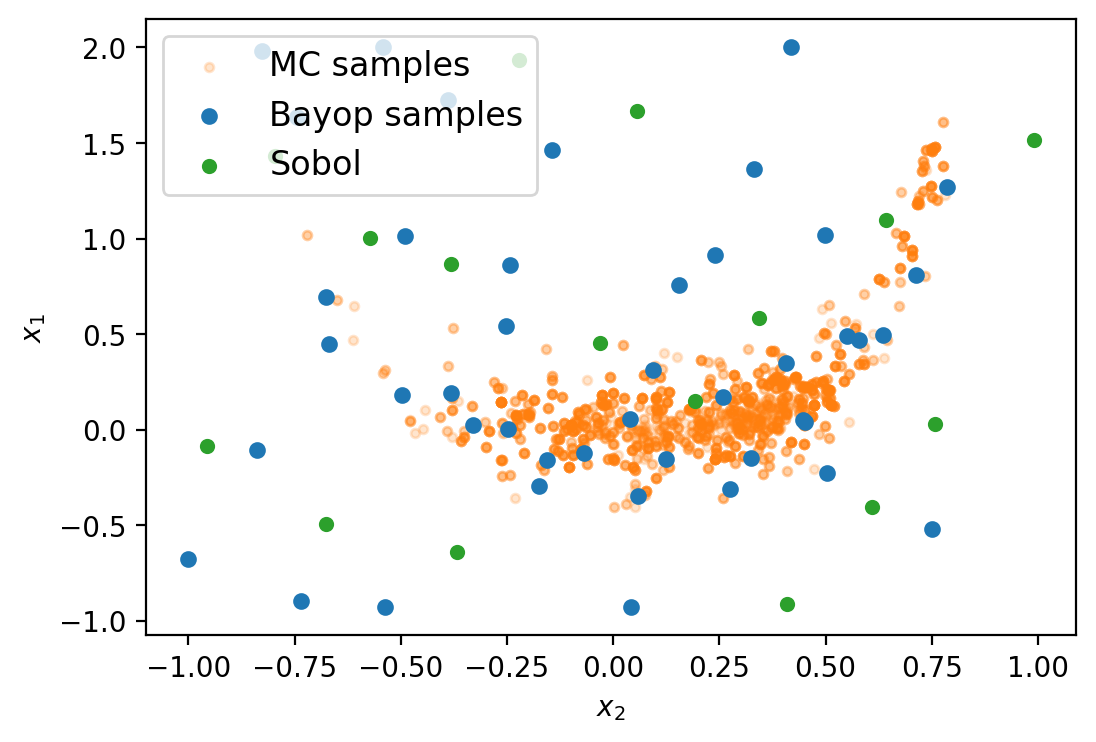

In [5]:
samples = input_unstandardize(samples_unit)

fig,ax = plt.subplots(1,int(ndim/2),figsize=(6,4))
# ax.scatter(samples_unit[:,0],samples_unit[:,0+1],s=10,label='MC samples unit',color='C3',alpha=0.2)
ax.scatter(samples[:,0],samples[:,0+1],s=10,label='MC samples',color='C1',alpha=0.2)
ax.scatter(train_x[ninit:,0],train_x[ninit:,0+1],s=25,label='Bayop samples',color='C0')
ax.scatter(train_x[:ninit,0],train_x[:ninit,0+1],s=20,label='Sobol',color='C2')
ax.set_ylabel(r'$x_1$')
ax.set_xlabel(r'$x_2$')
    # x.axvline(f_mean[2*i],ls='-.',color='k')
    # x.axhline(f_mean[2*i + 1],ls='-.',color='k')
ax.legend(fontsize=12)

In [6]:
### Run jaxns directly on loglike

def loglike(X):
    logpdf = -0.25*(5*(0.2-X[0]))**2 - (20*(X[1]/4 - X[0]**4))**2
    return logpdf


def prior_model():
    x = yield Prior(tfpd.Uniform(low=jnp.array([-1,-1]), high= jnp.array([1,2])), name='x')
    return x


model = Model(prior_model=prior_model,log_likelihood=loglike)

model.sanity_check(key=jax.random.PRNGKey(0), S=100)

from jaxns import NestedSampler, TerminationCondition

start = time.time()
ns = NestedSampler(model=model, max_samples=1e5,parameter_estimation=True,difficult_model=True)
term_cond = TerminationCondition(dlogZ=0.01)
# Run the sampler
termination_reason, state = ns(jax.random.PRNGKey(42),term_cond=term_cond)
# Get the results
results = ns.to_results(termination_reason=termination_reason, state=state)
print(f"Nested Sampling took {time.time() - start:.2f}s")
print(f"jaxns did {results.total_num_likelihood_evaluations} likelihood evaluations")
logz_dict = {"logz_mean": results.log_Z_mean, "dlogz": results.log_Z_uncert}
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

samples_jns = resample(key=jax.random.PRNGKey(0),
                    samples=results.samples,
                    log_weights=results.log_dp_mean,
                    replace=True,)
print(samples_jns['x'].shape)

INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


Nested Sampling took 2.90s
jaxns did 150677 likelihood evaluations
LogZ logz_mean: -3.0650, dlogz: 0.1648, 
(1612, 2)


In [31]:
samples_unit, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,num_samples_equal=900,difficult_model=True)
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))
samples = input_unstandardize(samples_unit)

INFO:[NS]: Nested Sampling took 3.65s
INFO:[NS]: jaxns did 131903 likelihood evaluations


LogZ logz_mean: -3.0971, dlogz: 0.1657, 


Removed no burn in
Removed no burn in


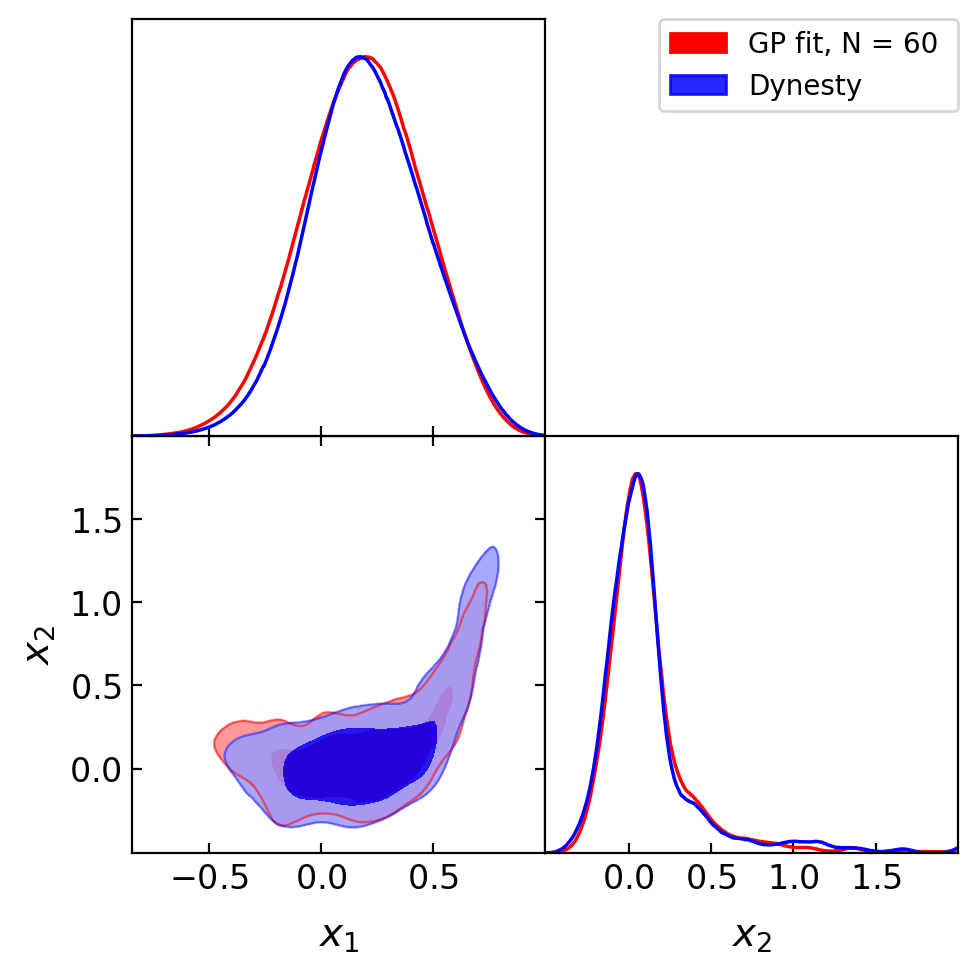

In [33]:
# test_samples = np.random.multivariate_normal(mean=f_mean,cov=cov,size=int(1e5))
labels = [r"x_{0}".format(i+1) for i in range(ndim)]
names = [r"x_{0}".format(i+1) for i in range(ndim)]
ranges =  param_bounds.T
f_mean = np.array([0.2,0.])
jns_samples = MCSamples(samples=samples_jns['x'][::4],names=names, labels = labels,ranges=ranges) # a comparison run
gp_samples = MCSamples(samples=samples[::3],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=2.5,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
# g.settings.axes_labelsize = 18
# g.settings.axes_fontsize = 16
# g.settings.legend_fontsize = 14
# g.settings.title_limit_fontsize = 14
g.settings.axes_labelsize = 16
g.settings.axes_fontsize = 14
g.settings.legend_fontsize = 12
g.triangle_plot([gp_samples,jns_samples], names,filled=[True,True],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]} ','Dynesty'],
                                contour_lws=[1.25,1.25], #markers = dict(zip(names,f_mean)),
                                marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'}) #,title_limit=1 ) # type: ignore

# for i in range(ndim):
#     ax = g.subplots[i,i]
#     ax.axvline(f_mean[i], color='C2', ls='-',lw=1.25)
plt.savefig('banana.pdf',bbox_inches='tight')